<a href="https://colab.research.google.com/github/luisfernandorios/Actividades_Aprendizaje-/blob/main/MNA_IAyAA_semana_7_Actividad_r5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Inteligencia Artificial y Aprendizaje Automático**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## **Adtividad de la Semana 7**
###**Red Neuronal Artificial - Perceptrón Multicapa : Multilayer Perceptrón (MLP)**


**Nombres y matrículas de los integrantes del equipo:**

*   Alberto Jose Garcia Porras (A01793509)
*   Carlos Julio León Caicedo (A01793947)
*   Luis Fernando Ríos Piedra (A00453954)
*   Marco Antonio Vázquez Morales (A01793704)

En cada sección deberás incluir todas las líneas de código necesarias para responder a cada uno de los ejercicios.

#**Contexto del problema y el conjunto de datos a utilizar**

El objetivo es determinar el impacto generado por un anuncio de una marca de cosméticos en Facebook, en el cual se intentaron varias variantes en la manera de mostrar el anuncio. Siguiendo el [artículo](https://www.semanticscholar.org/paper/Predicting-social-media-performance-metrics-and-of-Moro-Rita/dec55692590820754b53c916e29bb2b42c0e5104), deberás considerar como predictores o variables de entrada aquellas que se indican en la Tabla 3. Por otro lado, en la Tabla 2, los autores consideran varios casos para la variable de salida, intentando determinar cuál puede ser el mejor caso para medir el éxito de la campaña. Para este ejercicio deberás considerar únicamente los siguientes tres casos como variable de salida: “Lifetime post consumers”, “Lifetime People who have liked a Page and engaged with a post” y “Likes”. 

El conjunto de datos a utilizar es el de la siguiente liga de la UCI:
https://archive.ics.uci.edu/ml/datasets/Facebook+metrics


In [1]:
# Incluye aquí todos módulos, librerías y paquetes que requieras.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, zipfile
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer,classification_report
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold,RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from io import BytesIO

from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

#**Ejercicio-1.** 

En esta tarea considera únicamente la siguiente variable de salida que se concluye que es una de las mejores en el artículo antes citado:  ‘Lifetime People who have liked a Page and engaged with a post'. Renombra dicha variable como “LPE”. Como variables de entrada selecciona las 7 variables que indican los autores en la Tabla 3 del artículo citado.


In [30]:
path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip'
base_datos = path.split('/')[-1]
req_path = requests.get(path)

archivo_uci= zipfile.ZipFile(BytesIO(req_path.content))
archivo_uci.extractall('/content/sample_data/Facebook_metrics')
df = pd.read_csv("/content/sample_data/Facebook_metrics/dataset_Facebook.csv",sep=';')

df.rename(columns={'Lifetime People who have liked your Page and engaged with your post':'LPE'},
               inplace=True)
df.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,LPE,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [3]:
#Llenado de dato único dato nulo encontrado
df['Paid']=df['Paid'].fillna(0)

In [5]:
#Separación de variables numéricas y categóricas del df original
#Creación de dummies para variable Type
df_nums = df.select_dtypes(exclude='object')
df_objs = df.select_dtypes(include='object')
df_objs = pd.get_dummies(df_objs,drop_first=False)
final_df = pd.concat([df_nums,df_objs],axis=1)
final_df.columns

Index(['Page total likes', 'Category', 'Post Month', 'Post Weekday',
       'Post Hour', 'Paid', 'Lifetime Post Total Reach',
       'Lifetime Post Total Impressions', 'Lifetime Engaged Users',
       'Lifetime Post Consumers', 'Lifetime Post Consumptions',
       'Lifetime Post Impressions by people who have liked your Page',
       'Lifetime Post reach by people who like your Page', 'LPE', 'comment',
       'like', 'share', 'Total Interactions', 'Type_Link', 'Type_Photo',
       'Type_Status', 'Type_Video'],
      dtype='object')

In [6]:
#Generar df con variables finales para el modelo
var_input=final_df[['Category', 'Page total likes', 'Type_Photo', 'Type_Status',
       'Type_Video', 'Post Month', 'Post Hour', 'Post Weekday', 'Paid','LPE']]
# print(df[['Category', 'Page total likes', 'Type', 'Post Month', 'Post Hour', 'Post Weekday', 'Paid']])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


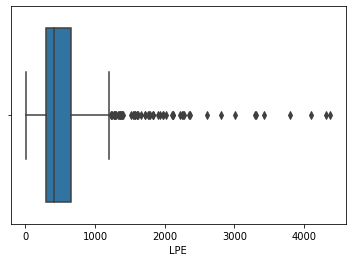

In [13]:
sns.boxplot(var_input['LPE'])

In [14]:
q75,q25=np.percentile(var_input['LPE'],[75,25])
IQR=q75-q25
upper_limit=q75+1.5*(IQR)
upper_limit

1204.125

In [15]:
ser=pd.Series(var_input['LPE'])

In [17]:
len(ser[ser<1204.125])

441

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


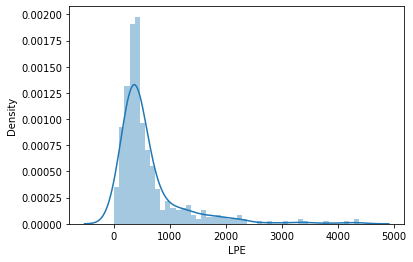

In [18]:
sns.distplot(var_input["LPE"])

In [90]:
from sklearn.preprocessing import power_transform
# Transf4 = power_transform(np.array(ser).reshape(-1,1),method="box-cox")
Transf4=np.log(ser)

In [92]:
yy=pd.Series(np.ravel(Transf4))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


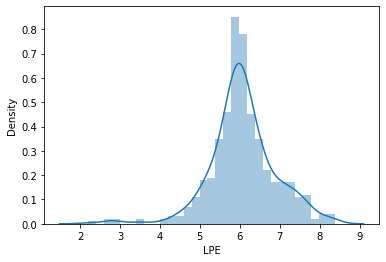

In [91]:
sns.distplot(Transf4)

In [7]:
var_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Category          500 non-null    int64  
 1   Page total likes  500 non-null    int64  
 2   Type_Photo        500 non-null    uint8  
 3   Type_Status       500 non-null    uint8  
 4   Type_Video        500 non-null    uint8  
 5   Post Month        500 non-null    int64  
 6   Post Hour         500 non-null    int64  
 7   Post Weekday      500 non-null    int64  
 8   Paid              500 non-null    float64
 9   LPE               500 non-null    int64  
dtypes: float64(1), int64(6), uint8(3)
memory usage: 28.9 KB


In [ ]:
var_input.describe(include='all')

,Category,Page total likes,Type_Photo,Type_Status,Type_Video,Post Month,Post Hour,Post Weekday,Paid,LPE
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.880000,123194.176000,0.852000,0.090000,0.014000,7.038000,7.840000,4.150000,0.278000,609.986000
std,0.852675,16272.813214,0.355456,0.286468,0.117608,3.307936,4.368589,2.030701,0.448462,612.725618
min,1.000000,81370.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,9.000000
25%,1.000000,112676.000000,1.000000,0.000000,0.000000,4.000000,3.000000,2.000000,0.000000,291.000000
50%,2.000000,129600.000000,1.000000,0.000000,0.000000,7.000000,9.000000,4.000000,0.000000,412.000000
75%,3.000000,136393.000000,1.000000,0.000000,0.000000,10.000000,11.000000,6.000000,1.000000,656.250000
max,3.000000,139441.000000,1.000000,1.000000,1.000000,12.000000,23.000000,7.000000,1.000000,4376.000000


In [40]:
# Definimos los atributos de entrada como 'X' y a la variable de salida como 'Y'
# Para este ejercicio deberás considerar únicamente los siguientes tres casos como variable de salida: 
# “Lifetime post consumers”, “Lifetime People who have liked a Page and engaged with a post” y “Likes”.

X = var_input.drop('LPE',axis=1)
y = var_input['LPE']

#Variables de salida de la Tabla 2, los autores consideran varios casos para la variable de salida
# Y=df['Lifetime post total reach','Lifetime post total impressions','Lifetime engaged users','Lifetime post consumers',
#      'Lifetime post consumotions','Lifetime post impressions by people who have liked a page','Lifetime post reach by people who like a page'
#      'Lifetime people who have liked a page and engaged with a post','Comments','Likes','Shares','Total interactions']

In [ ]:
var_input.columns


Index(['Category', 'Page total likes', 'Type_Photo', 'Type_Status',
       'Type_Video', 'Post Month', 'Post Hour', 'Post Weekday', 'Paid', 'LPE'],
      dtype='object')

In [41]:
X

,Page total likes,Category,Type_Photo,Type_Status,Type_Video,Post Month,Post Hour,Post Weekday,Paid,Type_Photo_2,Type_Status_2,Type_Video_2,Paid_2
0,2.000000,1.0,0.0,0.0,12.0,3.0,4.0,0.0,1.0,0.0,0.0,0.0,119.0
1,2.000000,0.0,1.0,0.0,12.0,10.0,3.0,0.0,0.0,1.0,0.0,0.0,1108.0
2,2.000000,1.0,0.0,0.0,12.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,132.0
3,2.000000,1.0,0.0,0.0,12.0,10.0,2.0,1.0,1.0,0.0,0.0,1.0,1386.0
4,2.000000,1.0,0.0,0.0,12.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,396.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.064111,1.0,0.0,0.0,1.0,2.0,7.0,0.0,1.0,0.0,0.0,0.0,392.0
496,1.000000,1.0,0.0,0.0,1.0,8.0,5.0,0.0,1.0,0.0,0.0,0.0,301.0
497,1.000000,1.0,0.0,0.0,1.0,2.0,5.0,0.0,1.0,0.0,0.0,0.0,363.0
498,1.000000,1.0,0.0,0.0,1.0,11.0,4.0,0.0,1.0,0.0,0.0,0.0,370.0


In [ ]:
y

0      1.025189
1      1.251660
2      1.028166
3      1.315319
4      1.088619
         ...   
495    1.087703
496    1.066865
497    1.081063
498    1.082665
499    1.070300
Name: LPE, Length: 500, dtype: float64

#**Ejercicio-2.**

Realiza una partición de los datos con 100 datos de Prueba y el resto para entrenamiento y validación.

In [ ]:
# # Definimos los atributos de entrada como 'X' y a la variable de salida como 'Y'
# # Para este ejercicio deberás considerar únicamente los siguientes tres casos como variable de salida: 
# # “Lifetime post consumers”, “Lifetime People who have liked a Page and engaged with a post” y “Likes”.

# var_otput = ['LPE']
# X = df[var_input]
# Y = df[var_otput]

# #Variables de salida de la Tabla 2, los autores consideran varios casos para la variable de salida
# # Y=df['Lifetime post total reach','Lifetime post total impressions','Lifetime engaged users','Lifetime post consumers',
# #      'Lifetime post consumotions','Lifetime post impressions by people who have liked a page','Lifetime post reach by people who like a page'
# #      'Lifetime people who have liked a page and engaged with a post','Comments','Likes','Shares','Total interactions']

In [155]:
#Partición de datos, test_size=100*100/500= 20%
X_train, X_test, y_train, y_test = train_test_split(X, yy, test_size=.20)


In [156]:
X_testt=X_test.reset_index().drop('index', axis='columns') 
y_testt=y_test.reset_index().drop('index', axis='columns') 

In [ ]:
np.ravel(y_train)

array([2126,  168,  762,  306,  167, 1834,  157,  403,  230,  391,  297,
        347, 1292,  293,  333, 1275, 1613,  814,  140,  340, 2119,  508,
       1200,  621,  705,  732, 1578,  477,  269,  630,  305,  559,  316,
        123,  152, 3430,  436, 1513,  342,  278,  435,  475, 2278,  985,
         59,  998, 1542,  119,  437,  646,  395, 1101,  340, 2256,  283,
        220,  393,  327,  319,   32,  240,  699,  413,  220,  471,  379,
        305,    9,  301,  576,  441,  275, 1779, 1276,  422,  287, 1146,
        240,  348,  456,   93,  375,  327,  392,  414,  392,  557,  100,
        289, 1356,  348,  300, 1086,  774,  563,   58, 1564,  465,  335,
        482,  236, 3798,  884,  885,  774, 1331,   92,  606,  156,  399,
        476,  248, 2342,  475,  447,  357,  327,  697,  594,  106, 1052,
        126,  363,  211,  590,  134,  462,  185, 1661,  403,  514,  447,
        268,  319,  569,  760,  291, 1233,  363,  236,  740,  375, 2252,
        907, 3316,  131,  408,  924, 3300,  347, 13

#**Ejercicio-3.**
Definirás tus propias funciones de errores para este problema de regresión. Los errores que utilizarás son la raíz cuadrada del error cuadrático medio RMSE, el error absoluto medio MAE y el error porcentual absoluto medio MAPE.

In [44]:
#Definiendo función RMSE
def mi_RMSE(y_val,yhatVal):
  return np.mean(np.sqrt(np.abs(y_val-yhatVal)))
#Definiendo función MAE
def mi_MAE(y_val,yhatVal):
  return np.mean(np.abs(y_val-yhatVal))
#Definiendo función MAPE
def mi_MAPE(y_val,yhatVal):
  return np.mean(np.abs((y_val-yhatVal)/y_val))*100

#**Ejercicio-4.**
En la página de la UCI, así como en el artículo de los autores previamente citado encuentras información en relación al significado de cada variable. Haz una análisis de tus datos y lleva a cabo las transformaciones que consideres adecuadas tanto en los datos de entrada, como en las de salida.
Utiliza un Pipeline para evitar el filtrado de información.


In [ ]:
# Transformaciones a factores numéricos de entrada:
num_pipe = Pipeline(steps = [('impMediana', SimpleImputer(strategy='median')),
                                 ('escalaNum', MinMaxScaler(feature_range=(1,2)))])   
num_pipe_nombres = [ 'Page total likes', 'LPE']

# Transformaciones a factores categóricos de entrada:
catImp_pipe = Pipeline(steps = [('impModa', SimpleImputer(strategy='most_frequent'))])  
catImp_pipe_nombres = ['Category', 'Type_Photo', 'Type_Status',
       'Type_Video', 'Post Month', 'Post Hour', 'Post Weekday','Paid']

catOHE_pipe = Pipeline(steps = [('OneHotE', OneHotEncoder(drop='first',handle_unknown='ignore'))])
catOHE_pipe_nombres = ['Type_Photo', 'Type_Status',
       'Type_Video','Paid']

# Conjuntamos las transformaciones numéricas y categóricas que se estarán aplicando a los datos de entrada:
columnasTransformer = ColumnTransformer(transformers = [('numpipe', num_pipe, num_pipe_nombres),
                                                        ('catimp', catImp_pipe, catImp_pipe_nombres),
                                                        ('catohe', catOHE_pipe, catOHE_pipe_nombres)],
                                        remainder='passthrough')

pipe = Pipeline(steps=[('ct',columnasTransformer)])

In [33]:
# Transformaciones a factores numéricos de entrada:
num_pipe = Pipeline(steps = [('impMediana', SimpleImputer(strategy='median')),
                                 ('escalaNum', MinMaxScaler(feature_range=(1,2)))])   
num_pipe_nombres = [ 'Page total likes']

# Transformaciones a factores categóricos de entrada:
catImp_pipe = Pipeline(steps = [('impModa', SimpleImputer(strategy='most_frequent'))])  
catImp_pipe_nombres = ['Category', 'Type_Photo', 'Type_Status',
       'Type_Video', 'Post Month', 'Post Hour', 'Post Weekday','Paid']

catOHE_pipe = Pipeline(steps = [('OneHotE', OneHotEncoder(drop='first',handle_unknown='ignore'))])
catOHE_pipe_nombres = ['Type_Photo', 'Type_Status',
       'Type_Video','Paid']

# Conjuntamos las transformaciones numéricas y categóricas que se estarán aplicando a los datos de entrada:
columnasTransformer = ColumnTransformer(transformers = [('numpipe', num_pipe, num_pipe_nombres),
                                                        ('catimp', catImp_pipe, catImp_pipe_nombres),
                                                        ('catohe', catOHE_pipe, catOHE_pipe_nombres)],
                                        remainder='passthrough')

pipe = Pipeline(steps=[('ct',columnasTransformer)])

In [42]:
pipe

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numpipe',
                                                  Pipeline(steps=[('impMediana',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('escalaNum',
                                                                   MinMaxScaler(feature_range=(1,
                                                                                               2)))]),
                                                  ['Page total likes']),
                                                 ('catimp',
                                                  Pipeline(steps=[('impModa',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Category', 'Type_P

In [34]:
pipe.fit(var_input)

var_input=pipe.transform(var_input)

var_input_df = pd.DataFrame(var_input)


In [35]:
var_input_df.columns=['Page total likes', 'LPE', 'Category','Type_Photo', 'Type_Status','Type_Video', 'Post Month','Post Hour', 'Post Weekday','Paid', 'Type_Photo_2', 'Type_Status_2', 'Type_Video_2', 'Paid_2']

In [36]:
var_input=var_input_df

In [39]:
# var_input_df.columns=(['Category', 'Page total likes', 'Type_Photo', 'Type_Status',
#        'Type_Video', 'Post Month', 'Post Hour', 'Post Weekday', 'Paid', 'LPE'],
#       dtype='object')

SyntaxError: ignored

#**Ejercicio-5.**
Utiliza la función Dummy para modelos de regresión de scikit-learn con el conjunto que tienes de datos de entrenamiento y validación. Para ello particiónalos en 100 para validación y 300 para entrenamiento. Encuentra los errores RMSE, MAE y MAPE para los conjuntos de entrenamiento y validación. 

Estos serán tus errores máximos que deberás tomar como referencia en el resto de la actividad. Consulta su documentación correspondiente: https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html

In [154]:
#Partición de datos, test_size=100*100/400= 25%
Xtrain, X_val, ytrain, y_val = train_test_split(X_train, y_train, test_size=.25)

In [220]:
from pandas.core.common import random_state
from sklearn.dummy import DummyRegressor

modeloDummy = DummyRegressor(strategy="mean")

XtrainFit_d = columnasTransformer.fit(Xtrain)   
XtrainTransf_d = XtrainFit_d.transform(Xtrain) 

modeloDummy=modeloDummy.fit(XtrainTransf_d, ytrain)

XvalTransf_d = XtrainFit_d.transform(X_val)
yhat = modeloDummy.predict(XvalTransf_d)

#modeloDummy.score(X_train,y_train)

print('Valor de RMSE a superar: %.4f' % np.mean(mi_RMSE(y_val,yhat)))
print("Valor del MAE a superar: %.4f" % np.mean(mi_MAE(y_val,yhat)))
print("Valor del MAPE a superar: %.4f" % np.mean(mi_MAPE(y_val,yhat)))

Valor de RMSE a superar: 0.6932
Valor del MAE a superar: 0.6138
Valor del MAPE a superar: 10.7640


#**Ejercicio-6.**
Usando los modelos de regresión lineal múltiple, el bosque aleatorio y el perceptrón multicapa con sus valores predeterminados, lleva a cabo su entrenamiento con repeticiones de validación cruzada (RepeatedKFold) y desplegando los errores RMSE, MAE y MAPE. Recuerda evitar el filtrado de
información usando los datos que obtuviste en el ejercicio 2. Incluye las conclusiones sobre el mejor modelo encontrado en esta primera aproximación. En particular ¿hay alguno sobreentrenado o subentrenado? NOTA: Recuerda que puedes aumentar en dado caso el número máximo de iteraciones para que todos los modelos converjan.

In [ ]:
cross_validate

In [254]:
def get_models():
  modelos = list()
  nombres = list()

  # LR - Regresión Lineal Multiiple:
  modelos.append(LinearRegression())
  nombres.append('LLM')

  # DT - Bosque Aleatorio:
  modelos.append(RandomForestClassifier())
  nombres.append('RF')
  
  # MLP - Red Neuronal Artificial / Perceptrón Lineal Multicapa:  
  # modelos.append(MLPClassifier( max_iter=3000))
  # nombres.append('MLP')
  #modelos.append(MLPRegressor(max_iter=3000))
  #nombres.append('MLP')
  
  return modelos, nombres


---


⚠ **¿Es el MLPClassifier o el MLPRegressor?**


---

In [52]:
X_test

,Page total likes,Category,Type_Photo,Type_Status,Type_Video,Post Month,Post Hour,Post Weekday,Paid,Type_Photo_2,Type_Status_2,Type_Video_2,Paid_2
85,1.961013,1.0,0.0,0.0,11.0,9.0,4.0,1.0,1.0,0.0,0.0,1.0,266.0
164,1.930895,1.0,0.0,0.0,9.0,10.0,5.0,0.0,1.0,0.0,0.0,0.0,204.0
229,1.865492,1.0,0.0,0.0,7.0,13.0,3.0,0.0,1.0,0.0,0.0,0.0,348.0
305,1.750288,1.0,0.0,0.0,6.0,2.0,4.0,0.0,1.0,0.0,0.0,0.0,569.0
32,1.990598,1.0,0.0,0.0,12.0,3.0,3.0,0.0,1.0,0.0,0.0,0.0,268.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,1.545160,1.0,0.0,0.0,4.0,5.0,5.0,0.0,1.0,0.0,0.0,0.0,758.0
411,1.440116,1.0,0.0,0.0,4.0,13.0,4.0,0.0,1.0,0.0,0.0,0.0,335.0
481,1.088185,0.0,0.0,0.0,1.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,59.0
472,1.169672,1.0,0.0,0.0,2.0,13.0,2.0,0.0,1.0,0.0,0.0,0.0,466.0


In [273]:
modelos, nombres = get_models()

scores_RMSEVal = list()
scores_MAEVal = list()
scores_MAPEVal = list()

filas = 15
columnas = 2

A=np.zeros([filas, columnas])


kf = RepeatedKFold(n_splits=5, n_repeats=3) 

  
for i in range(len(modelos)):
  j=0
  if i ==0:
    pipeline=Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])
  
    for train_index, test_index in kf.split(X_test):
      
      

      X__train, X__val = X_testt.loc[train_index], X_testt.loc[test_index]
      y__train, y__val = y_testt.loc[train_index], y_testt.loc[test_index]
      
      pipeline.fit(X__train,np.ravel(y__train))
      yhatVal=pipeline.predict(X__val)

      scores_RMSEVal.append(mi_RMSE(np.ravel(y__val), yhatVal))
      scores_MAEVal.append(mi_MAE(np.ravel(y__val), yhatVal))
      scores_MAPEVal.append(mi_MAPE(np.ravel(y__val), yhatVal))
      res=mi_MAPE(np.ravel(y__val), yhatVal)
      
      A[j,i]=res
      j=j+1
  # Desplegar información:
    
    print('>> %s:\nRMSE: %.3f \nMAE: %.3f  \nMAPE: %.3f' % (nombres[i],
                                                                 np.mean(scores_RMSEVal),
                                                                 np.mean(scores_MAEVal),
                                                                 np.mean(scores_MAPEVal)))

  if i==1:

    pipeline=Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])

    for train_index, test_index in kf.split(X_test):

        X__train, X__val = X_testt.loc[train_index], X_testt.loc[test_index]
        y__train, y__val = y_testt.loc[train_index], y_testt.loc[test_index]

        y__train[[0]]=y__train[[0]].astype('int')
        y__val[[0]]=y__val[[0]].astype('int')
 
        pipeline.fit(X__train,np.ravel(y__train))
        yhatVal=pipeline.predict(X__val)

        scores_RMSEVal.append(mi_RMSE(np.ravel(y__val), yhatVal))
        scores_MAEVal.append(mi_MAE(np.ravel(y__val), yhatVal))
        scores_MAPEVal.append(mi_MAPE(np.ravel(y__val), yhatVal))
        
        res=mi_MAPE(np.ravel(y__val), yhatVal)
        A[j,i]=res
        j=j+1

 
  # Desplegar información:
    
    print('>> %s:\nRMSE: %.3f \nMAE: %.3f  \nMAPE: %.3f' % (nombres[i],
                                                                 np.mean(scores_RMSEVal),
                                                                 np.mean(scores_MAEVal),
                                                                 np.mean(scores_MAPEVal)))

  if i ==2:

    pipeline=Pipeline(steps=[('ct',columnasTransformer),('m',modelos[i])])

    for train_index, test_index in kf.split(X_test):

      X__train, X__val = X_testt.loc[train_index], X_testt.loc[test_index]
      y__train, y__val = y_testt.loc[train_index], y_testt.loc[test_index]

      pipeline.fit(X__train,y__train)
      yhatVal=pipeline.predict(X__val)

      scores_RMSEVal.append(mi_RMSE(np.ravel(y__val), yhatVal))
      scores_MAEVal.append(mi_MAE(np.ravel(y__val), yhatVal))
      scores_MAPEVal.append(mi_MAPE(np.ravel(y__val), yhatVal))
      print(mi_MAPE(np.ravel(y__val), yhatVal))

  # Desplegar información:
    
    print('>> %s:\nRMSE: %.3f \nMAE: %.3f  \nMAPE: %.3f' % (nombres[i],
                                                                 np.mean(scores_RMSEVal),
                                                                 np.mean(scores_MAEVal),
                                                                 np.mean(scores_MAPEVal)))
  

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  UserWarning,


>> LLM:
RMSE: 0.495 
MAE: 0.319  
MAPE: 6.188
>> RF:
RMSE: 0.343 
MAE: 0.270  
MAPE: 5.456


#**Ejercicio-7.**
Obtener los diagramas de caja y bigote para los errores MAPE de los conjuntos de validación obtenidos. En particular compara estos primeros resultados de MAPE con el mejor resultado que encuentran los autores del artículo citado al inicio. Incluye tus conclusiones.

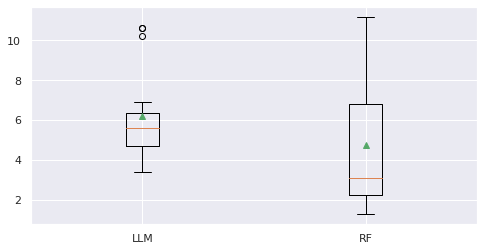

In [274]:
sns.set(rc={'figure.figsize':(8,4)})

plt.boxplot(A,labels=nombres,showmeans=True)
plt.show()

#**Ejercicio-8.**

Usando una búsqueda de malla con validación cruzada (GridSearchCV), busca los mejores hiperparámetros para el modelo MLP. Al menos deberás realizar la búsqueda en los hiperparámetros “hidden_layer_sizes”, “alpha” y “learning_rate_init”. Además aplica la validación cruzada con repeticiones (RepeatedKFold). Muestra los mejores hiperparámetros encontrados.

In [ ]:
XtrainTf = columnasTransformer.fit(X_train)
XtrainFTf = XtrainTf.transform(X_train)   
XtestFTf = XtrainTf.transform(X_test)

modelo_MLP=MLPClassifier(max_iter=3000)

cv = RepeatedKFold(n_splits=5, n_repeats=3)
grid_model_MLP = GridSearchCV(modelo_MLP,param_grid={"alpha": [0.0001, 0.001, 0.01, 0.1], "hidden_layer_sizes": [(10,30,10),(20,)], "learning_rate_init": np.linspace(0.00001, 1, 10)},cv=cv,scoring=make_scorer(mi_MAPE), n_jobs=-1)
#"hidden_layer_sizes":np.arange(1,5),
grid_model_MLP.fit(XtrainFTf,y_train)

print("Utilizando la métrica", grid_model_MLP.scoring, "la mejor puntuación obtenida es:", grid_model_MLP.best_score_)
print("Los mejores hiperparámetros encontrados son:", grid_model_MLP.best_params_)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1200 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 393, in _fit
    X, y = self._validate_input(X, y,

NotFittedError: ignored

#**Ejercicio-9.**
Con los mejores valores de los hiperparámetros encontrados realiza un análisis de la importancia de los factores. Muestra un diagrama de barras de los resultados e incluye tus conclusiones.

In [ ]:
for i,x in enumerate(scaled_Y_train_fit_transform):
    scaled_Y_train_fit_transform[i]=x.astype('int')

In [ ]:
print(scaled_Y_train_fit_transform)

[2. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 2. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 1. 0. 0. 0. 0. 2. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 4. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.
 4. 0. 0. 0. 4. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0.

In [ ]:
print(y_train.shape)

(400,)


In [ ]:
print(z)

[2126  168  762  306  167 1834  157  403  230  391  297  347 1292  293
  333 1275 1613  814  140  340 2119  508 1200  621  705  732 1578  477
  269  630  305  559  316  123  152 3430  436 1513  342  278  435  475
 2278  985   59  998 1542  119  437  646  395 1101  340 2256  283  220
  393  327  319   32  240  699  413  220  471  379  305    9  301  576
  441  275 1779 1276  422  287 1146  240  348  456   93  375  327  392
  414  392  557  100  289 1356  348  300 1086  774  563   58 1564  465
  335  482  236 3798  884  885  774 1331   92  606  156  399  476  248
 2342  475  447  357  327  697  594  106 1052  126  363  211  590  134
  462  185 1661  403  514  447  268  319  569  760  291 1233  363  236
  740  375 2252  907 3316  131  408  924 3300  347 1353  516 1609  408
   15  740  196  642  181 1392  351  584  460  454  323 1292  323  176
 1905  101  309  397  604  246  445   15  470  660  788  367  981 4318
  630  530  363  537  361  684  123  398  239  493  382  453  244  387
  263 

In [ ]:
print(scaled_Y_train_fit_transform)

[0.48477215 0.03640943 0.17242959 0.06801008 0.03618044 0.41790703
 0.03389054 0.09022212 0.05060682 0.08747424 0.06594916 0.07739867
 0.29379437 0.0650332  0.07419281 0.28990153 0.36730021 0.18433707
 0.02999771 0.07579574 0.48316922 0.11426609 0.27272727 0.14014197
 0.15937715 0.16555988 0.35928555 0.10716739 0.05953744 0.14220289
 0.06778109 0.12594458 0.07029998 0.02610488 0.03274559 0.78337531
 0.0977788  0.34440119 0.07625372 0.06159835 0.09754981 0.10670941
 0.51957866 0.22349439 0.01144951 0.22647126 0.35104191 0.02518892
 0.09800779 0.14586673 0.0883902  0.25005725 0.07579574 0.51454087
 0.0627433  0.04831692 0.08793222 0.07281887 0.07098695 0.00526677
 0.05289673 0.15800321 0.09251202 0.04831692 0.10579345 0.08472636
 0.06778109 0.         0.06686512 0.12983742 0.09892375 0.06091138
 0.40531257 0.29013052 0.09457293 0.06365926 0.2603618  0.05289673
 0.07762766 0.1023586  0.01923517 0.0838104  0.07281887 0.08770323
 0.09274101 0.08770323 0.1254866  0.0208381  0.06411724 0.3084

In [ ]:
MejorModelo_MLP = MLPClassifier(hidden_layer_sizes=(20,),
                            alpha=0.0001,
                            learning_rate_init=0.00001)

X_train_ajustado = columnasTransformer.fit(X_train)

X_train_ajustado_transformado = X_train_ajustado.transform(X_train)

scaler=MinMaxScaler()
z = np.array(y_train)
z.reshape(1, -1)
scaled_Y_train_fit = scaler.fit(z.reshape(-1,1))
scaled_Y_train_fit_transform = scaler.transform(z.reshape(-1,1))

scaled_Y_train_fit_transform = scaled_Y_train_fit_transform.reshape(-1)

MejorModelo_MLP.fit(X_train_ajustado_transformado, y_train)

Importancia_Factores = permutation_importance(MejorModelo_MLP, X_train_ajustado_transformado, scaled_Y_train_fit_transform, n_repeats=10)

print(Importancia_Factores)

ValueError: ignored

Atributo: 0, Puntuación: 0.00000
Atributo: 1, Puntuación: 0.00000
Atributo: 2, Puntuación: 0.00000
Atributo: 3, Puntuación: 0.00000
Atributo: 4, Puntuación: 0.00000
Atributo: 5, Puntuación: 0.00000
Atributo: 6, Puntuación: 0.00000
Atributo: 7, Puntuación: 0.00000
Atributo: 8, Puntuación: 0.00000
Atributo: 9, Puntuación: 0.00000
Atributo: 10, Puntuación: 0.00000
Atributo: 11, Puntuación: 0.00000
Atributo: 12, Puntuación: 0.00000
Atributo: 13, Puntuación: 0.00000


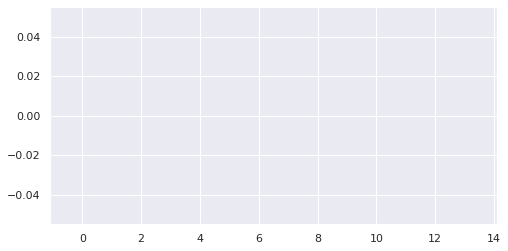

In [ ]:
for i, j in enumerate(Importancia_Factores['importances_mean']):
	print('Atributo: %0d, Puntuación: %.5f' % (i,j))

plt.bar([x for x in range(len(Importancia_Factores['importances_mean']))], Importancia_Factores['importances_mean'])
plt.show()

#**Ejercicio-10.**
Repite el ejercicio 8 y 9 para el modelo de bosque aleatorio para buscar sus mejores hiperparámetros (realiza la búsqueda con aquellos hiperparámetros que consideres más adecuados) y usando el conjunto de Prueba. Y realiza igualmente el análisis de importancia de factores con este modelo con un diagrama de barras.

In [ ]:
None

#**Ejercicio-11.**
Repite el ejercicio 8 y 9 para el modelo de regresión lineal múltiple para buscar sus mejores hiperparámetros (realiza la búsqueda con aquellos hiperparámetros que consideres más adecuados) y usando el conjunto de Prueba. Y realiza igualmente el análisis de importancia de factores con este modelo con un diagrama de barras.

In [ ]:
None

#**Ejercicio-12.**
Compara tus resultados con los obtenidos por los autores del artículo de Moro-Rita-Vala con respecto a MAPE. Incluye tus conclusiones finales de la actividad.


In [ ]:
None

###**Fin de la Actividad de la semana 7.**